<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Embedding" data-toc-modified-id="Embedding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embedding</a></span></li><li><span><a href="#VGGish-model" data-toc-modified-id="VGGish-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>VGGish model</a></span></li><li><span><a href="#YAMNet-model" data-toc-modified-id="YAMNet-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>YAMNet model</a></span></li><li><span><a href="#1-vs-rest" data-toc-modified-id="1-vs-rest-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1 vs rest</a></span></li><li><span><a href="#Yam+Vgg" data-toc-modified-id="Yam+Vgg-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Yam+Vgg</a></span></li><li><span><a href="#High-confidence-errors" data-toc-modified-id="High-confidence-errors-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>High confidence errors</a></span><ul class="toc-item"><li><span><a href="#Errors-on-train-set" data-toc-modified-id="Errors-on-train-set-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Errors on train set</a></span></li><li><span><a href="#Errors-on-validation-set" data-toc-modified-id="Errors-on-validation-set-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Errors on validation set</a></span></li></ul></li></ul></div>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
import pandas as pd
import numpy as np
from librosa.core import resample, load
from librosa.util import fix_length
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc
)
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import IPython

# Data

In [2]:
data = pd.read_csv('clean.csv')

In [3]:
all_classes = [c for c in data.columns if c.startswith('class')]
class_count = data[all_classes].idxmax(axis=1).value_counts()
class_count

class_Snare        2159
class_Kick         1557
class_Hat          1294
class_Tom          1259
class_Cymbal        727
class_Clap          312
class_Cowbell       153
class_Conga         121
class_Shaken        107
class_Tambourin      81
class_Bongo          60
class_Agogo          56
class_Clave          54
class_Timbales       49
class_Djembe         20
class_Guiro          19
class_Cajon          12
class_Cuica          10
class_Timpani        10
class_Tabla           9
class_Triangle        8
class_Gong            4
class_Darbuka         4
class_clave           2
dtype: int64

In [4]:
classes_cols = class_count[class_count > 100].index

In [5]:
nb_classes = len(classes_cols)
data = data[data[classes_cols].sum(axis=1) == 1]

In [6]:
data.shape

(7689, 46)

In [7]:
data.head()

,path,filename,dir_1,class_Hat,subclass_Hat_Open,subclass_Hat_Close,subclass_Hat_Foot,class_Bongo,class_Cymbal,subclass_Cymbal_Crash,...,subclass_Shaken_Maracas,class_Cajon,class_clave,dir_2,subclass_Snare_Off,subclass_Snare_On,subclass_Snare_Side,subclass_Snare_Flam,subclass_Snare_Brush,subclass_Cymbal_Trash
0,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 OPHAT2.wav,Yamaha RX-11,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD3.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD2.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 CLHAT2.wav,Yamaha RX-11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 RIDE.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data = data.loc[data['path'] != './Samples/200-drum-machines/Roland JV 1080/MaxV - Guiro.wav']

# Embedding

In [9]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [10]:
SR=16000
classes = data[classes_cols]
files = data['path']
vgg_embeddings = []
yam_embeddings = []
for path in tqdm(files):
    sound, _ = load(path, sr=SR)
    sound = fix_length(sound, 1*SR)
    vgg_embeddings.append(vggish(sound))
    _, yam_emb, _ = yamnet(sound)
    yam_embeddings.append(yam_emb[0])

vgg_embeddings = np.stack(vgg_embeddings)
yam_embeddings = np.stack(yam_embeddings)

In [11]:
vgg_embeddings.shape, yam_embeddings.shape

((7689, 1, 128), (7689, 1024))

In [12]:
vgg_embeddings = vgg_embeddings.reshape(-1, 128)
yam_embeddings = yam_embeddings.reshape(-1, 1024)

In [13]:
# x_train, x_valid, y_train, y_valid = train_test_split(sounds, classes, test_size=0.3, stratify=classes)
x_vgg_train, x_vgg_valid, x_yam_train, x_yam_valid, y_train, y_valid = train_test_split(vgg_embeddings, yam_embeddings, classes, test_size=0.3, stratify=classes)

In [14]:
x_vgg_train.shape

(5382, 128)

# VGGish model

In [15]:
inputs = Input(shape=(128))
x = Dense(100, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 459       
Total params: 18,409
Trainable params: 18,409
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_cols,
    y=y_train.idxmax(axis=1))

class_weights = dict(zip(range(nb_classes), class_weights))
class_weights

{0: 0.3957643944407677,
 1: 0.5486238532110091,
 2: 0.6600441501103753,
 3: 0.6787741203178207,
 4: 1.174852652259332,
 5: 2.743119266055046,
 6: 5.588785046728972,
 7: 7.035294117647059,
 8: 7.973333333333334}

In [18]:
history = model.fit(x_vgg_train, y_train, epochs=100, class_weight=class_weights, validation_data=(x_vgg_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.7109 - accuracy: 0.3222 - val_loss: 1.3084 - val_accuracy: 0.5358
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 1.1237 - accuracy: 0.5032 - val_loss: 1.1116 - val_accuracy: 0.6034
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.9352 - accuracy: 0.5769 - val_loss: 0.9858 - val_accuracy: 0.6385
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8174 - accuracy: 0.6167 - val_loss: 0.8465 - val_accuracy: 0.6944
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7853 - accuracy: 0.6302 - val_loss: 0.8422 - val_accuracy: 0.6896
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7335 - accuracy: 0.6498 - val_loss: 0.8061 - val_accuracy: 0.6875
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7214 - accuracy: 0.6616 - val_loss: 0.7613 - val_accuracy: 0.7126

Epoch 58/100
169/169 [==============================] - 0s 2ms/step - loss: 0.3397 - accuracy: 0.8129 - val_loss: 0.5123 - val_accuracy: 0.8106
Epoch 59/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3471 - accuracy: 0.8140 - val_loss: 0.5453 - val_accuracy: 0.8049
Epoch 60/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3393 - accuracy: 0.8222 - val_loss: 0.5696 - val_accuracy: 0.7889
Epoch 61/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3244 - accuracy: 0.8266 - val_loss: 0.5142 - val_accuracy: 0.8132
Epoch 62/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3214 - accuracy: 0.8227 - val_loss: 0.5187 - val_accuracy: 0.8153
Epoch 63/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3133 - accuracy: 0.8289 - val_loss: 0.5046 - val_accuracy: 0.8205
Epoch 64/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3359 - accuracy: 0.8274 - val_loss: 0.5248 - val_accuracy:

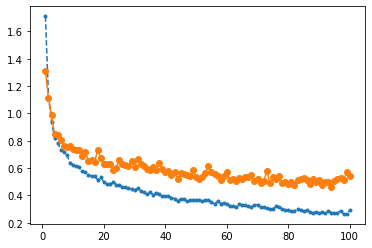

In [19]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [20]:
y_pred = model.predict(x_vgg_valid)
y_pred_class = np.argmax(y_pred,axis=1).astype(int)
y_valid_class = np.argmax(y_valid.values,axis=1).astype(int)

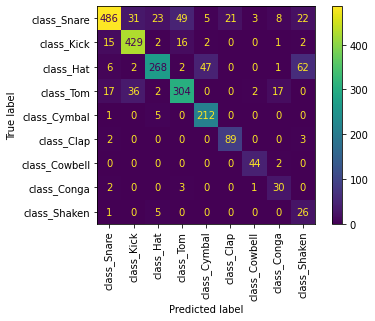

In [21]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [22]:
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.92      0.75      0.83       648
   class_Kick       0.86      0.92      0.89       467
    class_Hat       0.88      0.69      0.77       388
    class_Tom       0.81      0.80      0.81       378
 class_Cymbal       0.80      0.97      0.88       218
   class_Clap       0.81      0.95      0.87        94
class_Cowbell       0.88      0.96      0.92        46
  class_Conga       0.51      0.83      0.63        36
 class_Shaken       0.23      0.81      0.35        32

     accuracy                           0.82      2307
    macro avg       0.74      0.85      0.77      2307
 weighted avg       0.85      0.82      0.83      2307



In [23]:
roc_auc_score(y_valid_class, model.predict(x_vgg_valid), average='weighted', multi_class='ovr')

0.9730913322100873

# YAMNet model

In [24]:
inputs = Input(shape=(1024))
x = Dropout(0.3)(inputs)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(inputs)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 9225      
Total params: 9,225
Trainable params: 9,225
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model2.fit(x_yam_train, y_train, epochs=100, validation_data=(x_yam_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.4114 - accuracy: 0.4981 - val_loss: 1.1051 - val_accuracy: 0.6229
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 1.0484 - accuracy: 0.6269 - val_loss: 0.9443 - val_accuracy: 0.6779
Epoch 3/100
169/169 [==============================] - 0s 2ms/step - loss: 0.9291 - accuracy: 0.6698 - val_loss: 0.8710 - val_accuracy: 0.6866
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8716 - accuracy: 0.6852 - val_loss: 0.8198 - val_accuracy: 0.7109
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8285 - accuracy: 0.7001 - val_loss: 0.7872 - val_accuracy: 0.7204
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 0.7945 - accuracy: 0.7161 - val_loss: 0.7617 - val_accuracy: 0.7334
Epoch 7/100
169/169 [==============================] - 0s 2ms/step - loss: 0.7705 - accuracy: 0.7269 - val_loss: 0.7444 - val_accuracy: 0.7373

Epoch 58/100
169/169 [==============================] - 0s 1ms/step - loss: 0.5624 - accuracy: 0.7960 - val_loss: 0.5980 - val_accuracy: 0.7997
Epoch 59/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.7908 - val_loss: 0.5958 - val_accuracy: 0.7984
Epoch 60/100
169/169 [==============================] - 0s 1ms/step - loss: 0.5719 - accuracy: 0.7889 - val_loss: 0.5999 - val_accuracy: 0.7950
Epoch 61/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5673 - accuracy: 0.7900 - val_loss: 0.5950 - val_accuracy: 0.7932
Epoch 62/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.7912 - val_loss: 0.5963 - val_accuracy: 0.7976
Epoch 63/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.7904 - val_loss: 0.5971 - val_accuracy: 0.7984
Epoch 64/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5668 - accuracy: 0.7958 - val_loss: 0.5977 - val_accuracy:

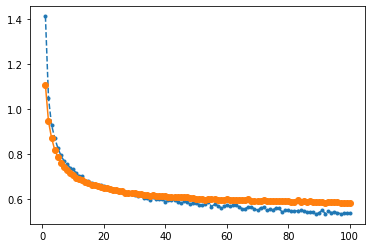

In [27]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [28]:
y_pred = model2.predict(x_yam_valid)
y_pred_class = np.argmax(y_pred,axis=1).astype(int)

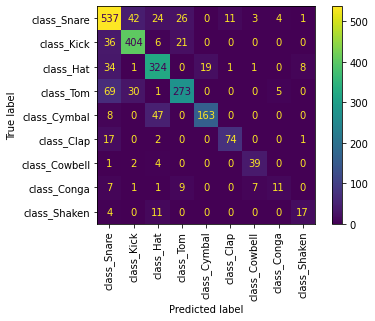

In [29]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [30]:
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.75      0.83      0.79       648
   class_Kick       0.84      0.87      0.85       467
    class_Hat       0.77      0.84      0.80       388
    class_Tom       0.83      0.72      0.77       378
 class_Cymbal       0.90      0.75      0.81       218
   class_Clap       0.86      0.79      0.82        94
class_Cowbell       0.78      0.85      0.81        46
  class_Conga       0.55      0.31      0.39        36
 class_Shaken       0.63      0.53      0.58        32

     accuracy                           0.80      2307
    macro avg       0.77      0.72      0.74      2307
 weighted avg       0.80      0.80      0.80      2307



In [31]:
roc_auc_score(y_valid_class, model2.predict(x_yam_valid), average='weighted', multi_class='ovr')

0.9612503708814677

# 1 vs rest

In [32]:
model.trainable = False
inputs = model.inputs
x = model.get_layer(index=-3).output
outputs = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs, outputs)
model3.summary()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
total = len(y_train['class_Shaken'])
positive = (y_train['class_Shaken'] == 1).sum()
negative = (y_train['class_Shaken'] == 0).sum()
weights = {0:(1 / negative)*(total)/2.0 ,1:(1 / positive)*(total)/2.0}
history = model3.fit(x_vgg_train, y_train['class_Shaken'], epochs=100, class_weight=weights, validation_data=(x_vgg_valid, y_valid['class_Shaken']))

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 18,001
Trainable params: 51
Non-trainable params: 17,950
_________________________________________________________________
Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5155 - accuracy: 0.7339 - val_loss: 0.

Epoch 51/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0506 - accuracy: 0.9740 - val_loss: 0.1082 - val_accuracy: 0.9640
Epoch 52/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0411 - accuracy: 0.9771 - val_loss: 0.1023 - val_accuracy: 0.9658
Epoch 53/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9797 - val_loss: 0.1033 - val_accuracy: 0.9658
Epoch 54/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0433 - accuracy: 0.9762 - val_loss: 0.1009 - val_accuracy: 0.9671
Epoch 55/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0447 - accuracy: 0.9775 - val_loss: 0.1035 - val_accuracy: 0.9662
Epoch 56/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0386 - accuracy: 0.9790 - val_loss: 0.0994 - val_accuracy: 0.9671
Epoch 57/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9768 - val_loss: 0.1039 - val_accuracy:

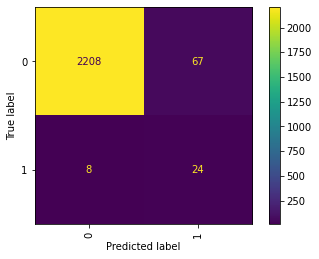

In [33]:
y_pred = model3.predict(x_vgg_valid)
y_pred_class = (y_pred > 0.5).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid['class_Shaken'], y_pred_class),
)
conf_matrix.plot(xticks_rotation=90);

In [34]:
print(classification_report(y_valid['class_Shaken'], y_pred_class))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      2275
         1.0       0.26      0.75      0.39        32

    accuracy                           0.97      2307
   macro avg       0.63      0.86      0.69      2307
weighted avg       0.99      0.97      0.98      2307



0.9748763736263736


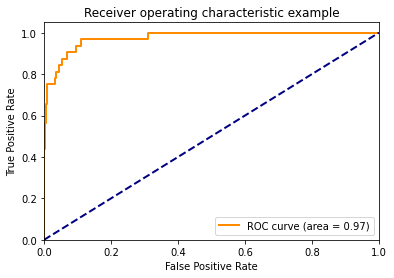

In [35]:
fpr, tpr, _ = roc_curve(y_valid['class_Shaken'], model3.predict(x_vgg_valid))
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Yam+Vgg

In [36]:
vgg_input = Input(shape=(128))
yam_input = Input(shape=(1024))
yam = Dropout(0.3)(yam_input)
x = Concatenate()([vgg_input,yam])
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model_vgg_yam = Model([vgg_input,yam_input], outputs)
model_vgg_yam.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1024)         0           input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1152)         0           input_3[0][0]                    
                                                                 dropout_5[0][0]       

In [37]:
model_vgg_yam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_vgg_yam.fit([x_vgg_train, x_yam_train], y_train, epochs=100, class_weight=class_weights, validation_data=([x_vgg_valid, x_yam_valid], y_valid))

Epoch 1/100
169/169 [==============================] - 0s 3ms/step - loss: 1.5004 - accuracy: 0.4078 - val_loss: 1.0421 - val_accuracy: 0.6121
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 0.9342 - accuracy: 0.5933 - val_loss: 0.8563 - val_accuracy: 0.6814
Epoch 3/100
169/169 [==============================] - 0s 3ms/step - loss: 0.7435 - accuracy: 0.6520 - val_loss: 0.7493 - val_accuracy: 0.7274
Epoch 4/100
169/169 [==============================] - 0s 2ms/step - loss: 0.6717 - accuracy: 0.6890 - val_loss: 0.7141 - val_accuracy: 0.7430
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.7079 - val_loss: 0.6132 - val_accuracy: 0.7733
Epoch 6/100
169/169 [==============================] - 1s 3ms/step - loss: 0.5958 - accuracy: 0.7211 - val_loss: 0.6687 - val_accuracy: 0.7581
Epoch 7/100
169/169 [==============================] - 0s 3ms/step - loss: 0.5457 - accuracy: 0.7419 - val_loss: 0.6059 - val_accuracy: 0.7798

169/169 [==============================] - 0s 3ms/step - loss: 0.2216 - accuracy: 0.8848 - val_loss: 0.4682 - val_accuracy: 0.8630
Epoch 58/100
169/169 [==============================] - 0s 3ms/step - loss: 0.2304 - accuracy: 0.8820 - val_loss: 0.4425 - val_accuracy: 0.8648
Epoch 59/100
169/169 [==============================] - 0s 2ms/step - loss: 0.2335 - accuracy: 0.8776 - val_loss: 0.4168 - val_accuracy: 0.8769
Epoch 60/100
169/169 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.8807 - val_loss: 0.4340 - val_accuracy: 0.8643
Epoch 61/100
169/169 [==============================] - 0s 2ms/step - loss: 0.2156 - accuracy: 0.8878 - val_loss: 0.4421 - val_accuracy: 0.8691
Epoch 62/100
169/169 [==============================] - 0s 3ms/step - loss: 0.2376 - accuracy: 0.8800 - val_loss: 0.4251 - val_accuracy: 0.8730
Epoch 63/100
169/169 [==============================] - 0s 2ms/step - loss: 0.2193 - accuracy: 0.8835 - val_loss: 0.4409 - val_accuracy: 0.8656
Epoch

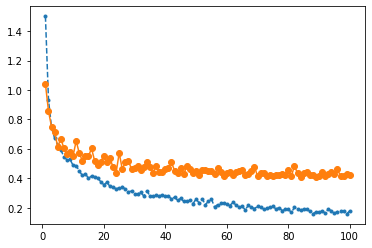

In [38]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

               precision    recall  f1-score   support

  class_Snare       0.93      0.83      0.88       648
   class_Kick       0.92      0.94      0.93       467
    class_Hat       0.89      0.88      0.88       388
    class_Tom       0.85      0.89      0.87       378
 class_Cymbal       0.93      0.92      0.92       218
   class_Clap       0.87      0.96      0.91        94
class_Cowbell       0.94      0.96      0.95        46
  class_Conga       0.57      0.81      0.67        36
 class_Shaken       0.56      0.88      0.68        32

     accuracy                           0.89      2307
    macro avg       0.83      0.89      0.85      2307
 weighted avg       0.89      0.89      0.89      2307



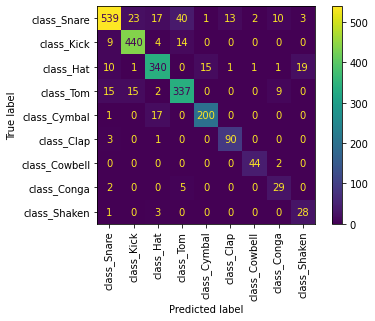

In [39]:
y_pred = model_vgg_yam.predict([x_vgg_valid, x_yam_valid])
y_pred_class = np.argmax(y_pred,axis=1).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

# High confidence errors

In [40]:
def show_errors(data, y, y_pred):
    y_class = np.argmax(y.values,axis=1).astype(int)
    for i in range(nb_classes):
        for j in range(nb_classes):
            if i == j:
                continue
            true_index = np.where(y_class==i)[0]
            pred_index = np.where(np.argmax(y_pred,axis=1).astype(int) == j)[0]
            index = list(set(true_index.tolist()) & set(pred_index.tolist()))
            if (len(index)==0):
                continue
            confidence = y_pred[index,j]
            index = index[np.argmax(confidence)]
            confidence = y_pred[index,j]
            index = y.iloc[[index]].index
            print(f'true: {classes_cols[i]}')
            print(f'pred: {classes_cols[j]}')
            print(f'confidence: {confidence}')
            path = data.loc[index, 'path'].values[0]
            print(path)
            sound, sr = load(path)
            IPython.display.display(IPython.display.Audio(sound, rate=sr, autoplay=False))    

## Errors on train set

In [41]:
show_errors(data, y_train, model_vgg_yam.predict([x_vgg_train, x_yam_train]))

true: class_Snare
pred: class_Kick
confidence: 0.9900298714637756
./Samples/wavegan-drums/train/Snare_02021.wav


true: class_Snare
pred: class_Hat
confidence: 0.9921525120735168
./Samples/200-drum-machines/Boss DR-202/202rim03.wav


true: class_Snare
pred: class_Tom
confidence: 0.9957025647163391
./Samples/wavegan-drums/train/Snare_01872.wav


true: class_Snare
pred: class_Cymbal
confidence: 0.9010047316551208
./Samples/wavegan-drums/train/Snare_01852.wav


true: class_Snare
pred: class_Clap
confidence: 0.9978410005569458
./Samples/wavegan-drums/train/Snare_01679.wav


true: class_Snare
pred: class_Cowbell
confidence: 0.9927173852920532
./Samples/200-drum-machines/Jomox Xbase-09/Snare02.wav


true: class_Snare
pred: class_Conga
confidence: 0.9975805282592773
./Samples/200-drum-machines/Roland TR-55/MaxV - Rim.wav


true: class_Snare
pred: class_Shaken
confidence: 0.9991937279701233
./Samples/wavegan-drums/train/Snare_01225.wav


true: class_Kick
pred: class_Snare
confidence: 0.9405456185340881
./Samples/200-drum-machines/Boss DR-660/DR-660Kick01.wav


true: class_Kick
pred: class_Tom
confidence: 0.8089113235473633
./Samples/wavegan-drums/train/Kick_02168.wav


true: class_Kick
pred: class_Clap
confidence: 0.6052449345588684
./Samples/wavegan-drums/train/Kick_00142.wav


true: class_Hat
pred: class_Snare
confidence: 0.6204876899719238
./Samples/wavegan-drums/train/Hat_01171.wav


true: class_Hat
pred: class_Cymbal
confidence: 0.912003755569458
./Samples/Hydrogen/Lightning1024/08-HiHatON-11.wav


true: class_Hat
pred: class_Shaken
confidence: 0.9383378624916077
./Samples/musicradar-essential-drumkit-samples/Foley Kit/Foley Fizz Hat 01.wav


true: class_Tom
pred: class_Snare
confidence: 0.7587203979492188
./Samples/wavegan-drums/train/Tom_00649.wav


true: class_Tom
pred: class_Kick
confidence: 0.9245678782463074
./Samples/wavegan-drums/valid/Tom_00061.wav


true: class_Tom
pred: class_Hat
confidence: 0.9701012372970581
./Samples/wavegan-drums/train/Tom_01871.wav


true: class_Tom
pred: class_Conga
confidence: 0.9861617088317871
./Samples/200-drum-machines/Roland Tr-808/TR-808Tom07.wav


true: class_Cymbal
pred: class_Hat
confidence: 0.6305634379386902
./Samples/200-drum-machines/KorgMP7/Cymbal1.wav


## Errors on validation set

In [42]:
show_errors(data, y_valid, model_vgg_yam.predict([x_vgg_valid, x_yam_valid]))

true: class_Snare
pred: class_Kick
confidence: 0.9793028235435486
./Samples/wavegan-drums/train/Snare_00808.wav


true: class_Snare
pred: class_Hat
confidence: 0.9988112449645996
./Samples/wavegan-drums/train/Snare_02072.wav


true: class_Snare
pred: class_Tom
confidence: 0.9979591369628906
./Samples/wavegan-drums/train/Snare_01757.wav


true: class_Snare
pred: class_Cymbal
confidence: 0.9041264057159424
./Samples/wavegan-drums/train/Snare_01270.wav


true: class_Snare
pred: class_Clap
confidence: 0.9977452158927917
./Samples/200-drum-machines/Korg prophecy/MaxV - KR - Snaredrum 04.wav


true: class_Snare
pred: class_Cowbell
confidence: 0.9922372698783875
./Samples/wavegan-drums/train/Snare_01501.wav


true: class_Snare
pred: class_Conga
confidence: 0.9770087599754333
./Samples/wavegan-drums/train/Snare_01796.wav


true: class_Snare
pred: class_Shaken
confidence: 0.9961234927177429
./Samples/wavegan-drums/valid/Snare_00241.wav


true: class_Kick
pred: class_Snare
confidence: 0.9247025847434998
./Samples/wavegan-drums/train/Kick_01708.wav


true: class_Kick
pred: class_Hat
confidence: 0.8563035130500793
./Samples/200-drum-machines/Ruby Orla/MaxV - Kick.wav


true: class_Kick
pred: class_Tom
confidence: 0.9959779977798462
./Samples/Hydrogen/Millo-Drums_v.1/bd1.flac


true: class_Hat
pred: class_Snare
confidence: 0.9999995231628418
./Samples/wavegan-drums/train/Hat_00327.wav


true: class_Hat
pred: class_Kick
confidence: 0.6780306696891785
./Samples/Hydrogen/ElectricEmpireKit/EE_Hat_Ring_2.flac


true: class_Hat
pred: class_Cymbal
confidence: 0.995287299156189
./Samples/musicradar-drum-samples/Drum Kits/Kit 2 - Acoustic room/CYCdh_K2room_PdHat-04.wav


true: class_Hat
pred: class_Clap
confidence: 0.6799603700637817
./Samples/musicradar-essential-drumkit-samples/Chip Tune Kit/ChipTune Open Hat 01.wav


true: class_Hat
pred: class_Cowbell
confidence: 0.5319873690605164
./Samples/musicradar-drum-samples/Drum Kits/Kit 14 - Acoustic/CYCdh_K5-ClHat01.wav


true: class_Hat
pred: class_Conga
confidence: 0.6516573429107666
./Samples/Hydrogen/VariBreaks/VP Hat 1 Cl.flac


true: class_Hat
pred: class_Shaken
confidence: 0.992405116558075
./Samples/musicradar-essential-drumkit-samples/Dusty Break Kit/Dusty Closed Hat 02.wav


true: class_Tom
pred: class_Snare
confidence: 0.9987144470214844
./Samples/wavegan-drums/valid/Tom_00242.wav


true: class_Tom
pred: class_Kick
confidence: 0.9751967191696167
./Samples/wavegan-drums/train/Tom_02211.wav


true: class_Tom
pred: class_Hat
confidence: 0.8516430258750916
./Samples/200-drum-machines/mercure_drums/gd-tom8.wav


true: class_Tom
pred: class_Conga
confidence: 0.9886252880096436
./Samples/Hydrogen/VariBreaks/VP Tom Hi.flac


true: class_Cymbal
pred: class_Snare
confidence: 0.48889675736427307
./Samples/musicradar-essential-drumkit-samples/Chip Tune Kit/ChipTune Cymbal 01.wav


true: class_Cymbal
pred: class_Hat
confidence: 0.9999998807907104
./Samples/musicradar-drum-samples/Drum Kits/Kit 13 - Acoustic/CYCdh_K4-Trash07.wav


true: class_Clap
pred: class_Snare
confidence: 0.9675604701042175
./Samples/musicradar-essential-drumkit-samples/Vermona DRM1 Kit/Vermona Clap 01.wav


true: class_Clap
pred: class_Hat
confidence: 0.32571008801460266
./Samples/musicradar-essential-drumkit-samples/Vintage Drumbox Kit/Vintage Clap 02.wav


true: class_Cowbell
pred: class_Conga
confidence: 0.9894469976425171
./Samples/wavegan-drums/valid/Cowbell_00277.wav


true: class_Conga
pred: class_Snare
confidence: 0.7782503366470337
./Samples/200-drum-machines/Roland Tr-626/TR-626Conga_MutHi.wav


true: class_Conga
pred: class_Tom
confidence: 0.9741348028182983
./Samples/200-drum-machines/Roland Tr-808/TR-808Conga05.wav


true: class_Shaken
pred: class_Snare
confidence: 0.6932185292243958
./Samples/200-drum-machines/Roland MC303/MaxV - Shakecla.wav


true: class_Shaken
pred: class_Hat
confidence: 0.9529325366020203
./Samples/Hydrogen/ErnysPercussion/Cabasa Cut.wav
